# Importacion de librerias

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import numpy as np
import seaborn as sns
import datetime as dt
import cufflinks as cf
from IPython.display import display, HTML
from sodapy import Socrata
import streamlit as st
import plotly.graph_objects as go
import plotly.express as px

cf.set_config_file(sharing='public', theme='ggplot', offline=True)

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

________
# Campo de funciones

Con está función llamamos un data set para normalizar los nombre de los estados, ya que se encuentrán en código

In [2]:
def nom_est():
        #nombre de los estados
    nam = pd.read_html('https://es.wikipedia.org/wiki/Estado_de_los_Estados_Unidos')[1]
    nam = nam[['Abrev.','Estado']]
    nam.rename(columns={'Abrev.':'state', 'Estado':'state_name'}, inplace=True)
    return nam

Cargamos la data y normalizamos y implementamos los nombre según su código

In [3]:
def cargadata():
    #descarga de datos y limpieza
    df = pd.read_csv('D:\Proyectos\DS-PI-ProyectoIndividual\data\COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries.csv')
    df = pd.merge(df, nom_est()[['state', 'state_name']], on=['state'], how='left')
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date'])
    df['Year']  = pd.DatetimeIndex(df['date']).year
    df.reset_index(drop=True, inplace=True)
    
    return df

______
# importación de datos

In [6]:
nam = nom_est()
df = cargadata()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2384\3184116154.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



____
##### 1 - ¿Cuáles fueron los 5 Estados con mayor ocupación hospitalaria por COVID? Criterio de ocupación por cama común. Considere la cantidad de camas ocupadas con pacientes confirmados y tome como referencia los 6 primeros meses del 2020 - recuerde incluir la cifra de infectados en esos meses (acumulativo). ¿Influye el rango etario en este comportamiento?

los rango rangos estarios se implementaron en el 30/04/2021

In [185]:
df01 = df.loc[:,['state', 'date', 'inpatient_beds', 'inpatient_beds_used_covid', 'percent_of_inpatients_with_covid']]
df01 = df01.loc[(df01['date'] >= '2020-01-01') & (df01['date'] <= '2020-06-30')]

In [186]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 0 to 6693
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   state                             6694 non-null   object        
 1   date                              6694 non-null   datetime64[ns]
 2   inpatient_beds                    6689 non-null   float64       
 3   inpatient_beds_used_covid         6610 non-null   float64       
 4   percent_of_inpatients_with_covid  6343 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 313.8+ KB


In [187]:
df01.isna().sum()

state                                 0
date                                  0
inpatient_beds                        5
inpatient_beds_used_covid            84
percent_of_inpatients_with_covid    351
dtype: int64

In [188]:
df01 = df01[df01['inpatient_beds'].notna()] 
df01 = df01.fillna(0) #remplazo nan

Obtenemos los datos a usar, realizamos el check de los datos y eliminamos los nulos 'inpatien_beds' y remplazamos los NAN, por la cantidad de nulos que teniamos
______

In [189]:
df01['Percentege_bed_used'] = df01['inpatient_beds_used_covid'] / df01['inpatient_beds'] #obtuve porcentaje de camas usadas
df01.head(3)

,state,date,inpatient_beds,inpatient_beds_used_covid,percent_of_inpatients_with_covid,Percentege_bed_used
0,NC,2020-01-01,72.0,0.0,0.0,0.0
1,HI,2020-01-01,0.0,0.0,0.0,NaN
2,PR,2020-01-01,146.0,0.0,0.0,0.0


In [190]:
df01 = df01.fillna(0) #remplazo nan

In [182]:
tot_inf = df01.groupby('state')['percent_of_inpatients_with_covid'].mean()
tot_inf = tot_inf.reset_index()

In [191]:
# Realice un agrupamiento por la media de ocupacion hospitalaria en los estados
df01 = df01.groupby('state')['Percentege_bed_used'].mean()
df01 = df01.reset_index()
df01['Percentege_bed_used'] = df01['Percentege_bed_used'].apply(lambda x: x * 100) #con la función lambda lo pasamos a formato porcentaje 

In [169]:
df01 = pd.merge(df01, tot_inf[['state', 'percent_of_inpatients_with_covid']], on=['state'], how='left')

In [192]:
df01.head(1)

,state,Percentege_bed_used
0,AK,1.414621


In [194]:
col = ['state', 'Percentege_bed_used']
top05 = df01.nlargest(5, 'Percentege_bed_used')[col] #con esta funcion obtengo los 5 estados con media mas alta
top05 = pd.merge(top05, nam[['state', 'state_name']], on=['state'], how='left') #normalizo el nombre con el codigo
first_column = top05.pop('state_name')   #obtengo la columna a mover
top05.insert(0, 'state_name', first_column) #se coloca la columa a primera posicion
top05.set_index('state', inplace=True)

In [195]:
df01 = df01.sort_values('Percentege_bed_used', ascending=False) #ordenamos los valores para graficar uniformenete

In [196]:
#top05['percent_of_inpatients_with_covid'] = top05['percent_of_inpatients_with_covid'].round(2)
top05['Percentege_bed_used'] = top05['Percentege_bed_used'].round(2)

In [197]:
top05

,state_name,Percentege_bed_used
state,,
NY,Nueva York[19]​,21.35
NJ,Nueva Jersey[17]​,20.24
MA,Massachusetts,17.77
CT,Connecticut,14.55
LA,Luisiana[10]​,13.78


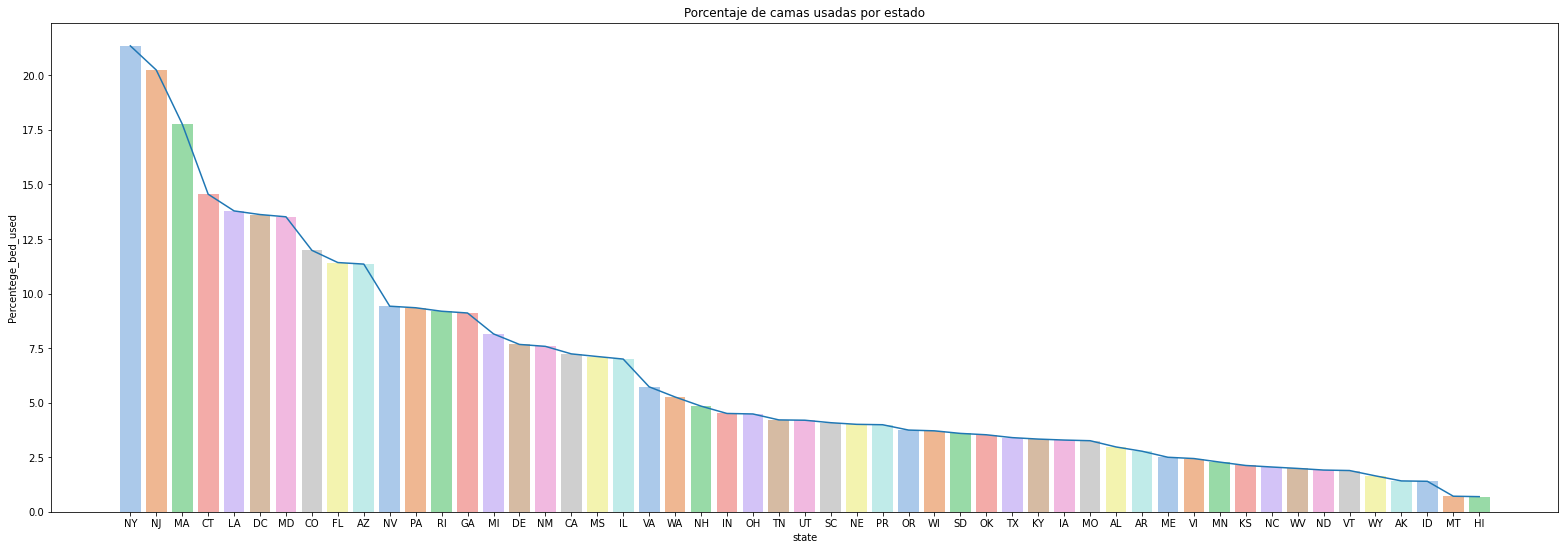

Los 5 estados con mayor ocupación hospitalaria por COVID: 
               state_name  Percentege_bed_used
state                                        
NY       Nueva York[19]​            21.347304
NJ     Nueva Jersey[17]​            20.240464
MA         Massachusetts            17.767949
CT           Connecticut            14.550693
LA         Luisiana[10]​            13.784827


In [64]:
plt.figure(figsize=(27,9), facecolor='white')
ax = sns.barplot(data=df01, x="state", y="Percentege_bed_used", palette='pastel')
plt.plot(df01.state,df01['Percentege_bed_used'])
plt.title('Porcentaje de camas usadas por estado')
plt.show()
print('Los 5 estados con mayor ocupación hospitalaria por COVID: \n' , top05.to_markdown() )

In [199]:
fig = px.bar(df01.head(10), x='state', y='Percentege_bed_used', color='Percentege_bed_used', title='Porcentaje de camas usadas por estado ')
fig.show()
print('Los 5 estados con mayor ocupación hospitalaria por COVID: \n' , top05.to_markdown())

Los 5 estados con mayor ocupación hospitalaria por COVID: 
 | state   | state_name       |   Percentege_bed_used |
|:--------|:-----------------|----------------------:|
| NY      | Nueva York[19]​   |                 21.35 |
| NJ      | Nueva Jersey[17]​ |                 20.24 |
| MA      | Massachusetts    |                 17.77 |
| CT      | Connecticut      |                 14.55 |
| LA      | Luisiana[10]​     |                 13.78 |


_____
##### 2 - Analice la ocupación de camas (Común) por COVID en el Estado de Nueva York durante la cuarentena establecida e indique:
- Intervalos de crecimiento y decrecimiento
- Puntos críticos (mínimos y máximos)

In [17]:
# Obtenemos la data con los campos requeridos y seleccionamos el rango de fechas a analisar
df02 = df.loc[:,['state', 'date', 'inpatient_beds', 'inpatient_beds_used_covid']]
df02 = df02.loc[(df02['date'] >= '2020-03-22') & (df02['date'] <= '2020-06-13')]
df02 = df02[df02['state']== 'NY']
df_fin = df02.copy()

In [18]:
from scipy.signal import find_peaks #con esta libreria obtenemos los picos 
peaks, _ =find_peaks(df02.inpatient_beds_used_covid, prominence=1)
df02['minima'] = df02['inpatient_beds_used_covid']*-1 #convierto a negativo para obtener los picos minimos
peaks1, _ =find_peaks(df02.minima, prominence=1)

In [19]:
# Agrupo por fecha los pacientes que usan ccamas por COVID
df02 = df02.groupby('date')['inpatient_beds_used_covid'].sum()

In [20]:
pi01 = [] 
for i in df02[peaks].index.strftime('%Y-%m-%d'): #Agrego a una lista las fechas con los picos maximos
    pi01.append(i)
    
pi02 = []
for i in df02[peaks1].index.strftime('%Y-%m-%d'): #Agrego a una lista las fechas con los los picos minimos
    pi02.append(i)

In [23]:
#convirtiendo los datos de picos en Dataframe
pi01 = pd.DataFrame(pi01)
pi01.rename(columns={0:'date'}, inplace=True)
pi01['Desc'] = 'Pico Maximo'

pi02 = pd.DataFrame(pi02)
pi02.rename(columns={0:'date'}, inplace=True)
pi02['Desc'] = 'Pico Minimo'

pi01 = pi01.reset_index()
pi02 = pi02.reset_index()
#Concatenamos en un dataframe los picos
picos = pd.concat([pi01, pi02])
picos = picos.sort_values('index', ascending=True)
picos['date'] = pd.to_datetime(picos['date'])
picos = pd.merge(picos, df_fin[['date', 'inpatient_beds_used_covid']], on=['date'], how='left')
picos = picos.drop(['index'], axis=1)
first_column = picos.pop('Desc')   
picos.insert(0, 'Desc', first_column) 
picos= picos.dropna()

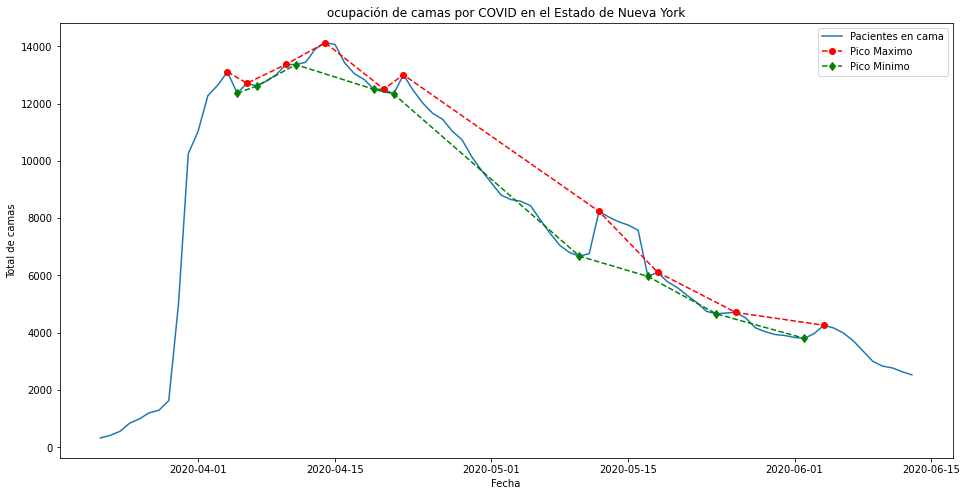

Fechas con picos maximos:  |    | Desc        | date                |   inpatient_beds_used_covid |
|---:|:------------|:--------------------|----------------------------:|
|  0 | Pico Maximo | 2020-04-04 00:00:00 |                       13107 |
|  1 | Pico Minimo | 2020-04-05 00:00:00 |                       12363 |
|  2 | Pico Maximo | 2020-04-06 00:00:00 |                       12711 |
|  3 | Pico Minimo | 2020-04-07 00:00:00 |                       12611 |
|  4 | Pico Maximo | 2020-04-10 00:00:00 |                       13369 |
|  5 | Pico Minimo | 2020-04-11 00:00:00 |                       13361 |
|  6 | Pico Maximo | 2020-04-14 00:00:00 |                       14126 |
|  7 | Pico Minimo | 2020-04-19 00:00:00 |                       12496 |
|  8 | Pico Maximo | 2020-04-20 00:00:00 |                       12507 |
|  9 | Pico Minimo | 2020-04-21 00:00:00 |                       12335 |
| 10 | Pico Maximo | 2020-04-22 00:00:00 |                       13005 |
| 11 | Pico Minimo | 202

In [60]:
plt.figure(figsize=(16,8), facecolor='white')
plt.plot(df02)
plt.plot(df02[peaks],  marker='o', linestyle='dashed', color='red')
plt.plot(df02[peaks1],  marker='d', linestyle='dashed', color='green')
plt.xlabel('Fecha')
plt.ylabel('Total de camas')
plt.title('ocupación de camas por COVID en el Estado de Nueva York')
plt.legend(['Pacientes en cama', 'Pico Maximo', 'Pico Minimo'], loc='upper right')
plt.show()

print("Fechas con picos maximos: ", picos.to_markdown())

##### 3 - ¿Cuáles fueron los cinco Estados que más camas UCI -Unidades de Cuidados Intensivos- utilizaron durante el año 2020? La medición debe realizarse en términos absolutos.

In [28]:
df03 = df.loc[:,['state', 'date', 'inpatient_beds', 'adult_icu_bed_utilization_numerator', 'staffed_pediatric_icu_bed_occupancy']]
df03['Year']  = pd.DatetimeIndex(df03['date']).year
#filtrado por año
df03 = df03.loc[(df03['Year'] == 2020)]

In [29]:
df03.isna().sum()

state                                     0
date                                      0
inpatient_beds                            5
adult_icu_bed_utilization_numerator    7196
staffed_pediatric_icu_bed_occupancy    7735
Year                                      0
dtype: int64

In [30]:
df03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16445
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   state                                16446 non-null  object        
 1   date                                 16446 non-null  datetime64[ns]
 2   inpatient_beds                       16441 non-null  float64       
 3   adult_icu_bed_utilization_numerator  9250 non-null   float64       
 4   staffed_pediatric_icu_bed_occupancy  8711 non-null   float64       
 5   Year                                 16446 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 899.4+ KB


In [31]:
df03 = df03.dropna()

In [32]:
len(df03.date.unique())

254

In [33]:
df03['total_icu_bed_use'] = df03['adult_icu_bed_utilization_numerator'] + df03['staffed_pediatric_icu_bed_occupancy']

In [34]:
df03 = df03.groupby('state')['total_icu_bed_use'].sum()
df03 = df03.reset_index()
df03['total_camas'] = df03.total_icu_bed_use / 254

In [35]:
col = ['state', 'total_camas']
top05_3 = df03.nlargest(5, 'total_camas')[col]
top05_3 = pd.merge(top05_3, nam[['state', 'state_name']], on=['state'], how='left')
first_column = top05_3.pop('state_name')   
top05_3.insert(0, 'state_name', first_column)

In [36]:
top05_3 = top05_3.round()
df03 = df03.sort_values('total_icu_bed_use', ascending=False)

In [42]:
df03.head(1)

,state,total_icu_bed_use,total_camas
4,CA,1121942.0,4417.094488


In [50]:
def linealPlot(df_new, x, y):
    fig= go.Figure(data=[
        go.Bar(
        x=df_new[x],
        y=df_new[y]
        )
    ])
    fig.update_layout(
        height=300, width=1000,
        plot_bgcolor='black',
        paper_bgcolor= 'black',
        font_color='#cee3e1',
        legend=dict(
            x=0.05,
            y=1,
            title_font_family="Times New Roman",
            font=dict(
                family="Courier",
                size=12,
color="LightSteelBlue"
            ),
            bgcolor="Black",
            bordercolor="LightSteelBlue",
            borderwidth=1
        ),
        xaxis=dict(showgrid=False,showline=True,linecolor='rgb(255,255,255)'),
        yaxis=dict(showgrid=False),
        margin=dict(l=10,r=10,b=10,t=10)
    )
    return fig

In [53]:
print('Los estados con ocuparon mas camas UCI, 2020: \n' , top05_3.to_markdown() )
linealPlot(df03, 'state', 'total_camas')

Los estados con ocuparon mas camas UCI, 2020: 
 |    | state_name      | state   |   total_camas |
|---:|:----------------|:--------|--------------:|
|  0 | California      | CA      |          4417 |
|  1 | Texas[27]​       | TX      |          4097 |
|  2 | Florida         | FL      |          3523 |
|  3 | Nueva York[19]​  | NY      |          2448 |
|  4 | Pensilvania[25]​ | PA      |          2180 |


In [68]:
# Plotting 20 Países 2021
fig = px.bar(df03.head(10), x='state', y='total_camas', color='total_camas', title='Top 05 estados Los estados con ocuparon mas camas UCI, 2020 ')
fig.show()
print('Los estados con ocuparon mas camas UCI, 2020: \n' , top05_3.to_markdown() )

Los estados con ocuparon mas camas UCI, 2020: 
 |    | state_name      | state   |   total_camas |
|---:|:----------------|:--------|--------------:|
|  0 | California      | CA      |          4417 |
|  1 | Texas[27]​       | TX      |          4097 |
|  2 | Florida         | FL      |          3523 |
|  3 | Nueva York[19]​  | NY      |          2448 |
|  4 | Pensilvania[25]​ | PA      |          2180 |


4 - ¿Qué cantidad de camas se utilizaron, por Estado, para pacientes pediátricos con COVID durante el 2020?

In [77]:
df04 = df.loc[:,['state', 'state_name', 'date', 'inpatient_beds', 'all_pediatric_inpatient_bed_occupied']]
df04['Year']  = pd.DatetimeIndex(df04['date']).year
#filtrado por año
df04 = df04.loc[(df04['Year'] == 2020)]

In [78]:
df04.isna().sum()

state                                      0
state_name                               858
date                                       0
inpatient_beds                             5
all_pediatric_inpatient_bed_occupied    7731
Year                                       0
dtype: int64

In [79]:
df04.tail()

,state,state_name,date,inpatient_beds,all_pediatric_inpatient_bed_occupied,Year
16441,ND,Dakota del Norte,2020-12-31,2456.0,206.0,2020
16442,NC,Carolina del Norte,2020-12-31,24073.0,263.0,2020
16443,TX,Texas[27]​,2020-12-31,70852.0,387.0,2020
16444,ID,Idaho,2020-12-31,3738.0,227.0,2020
16445,IA,Iowa,2020-12-31,8120.0,NaN,2020


In [80]:
df04 = df04.dropna()
dimension = len(df04.date.unique())

In [81]:
df04 = df04.groupby('state')['all_pediatric_inpatient_bed_occupied'].sum()
df04 = df04.reset_index()

In [82]:
df04['total_camas_pedia'] = df04.all_pediatric_inpatient_bed_occupied / dimension

In [83]:
col = ['state', 'total_camas_pedia']
top05_4 = df04.nlargest(5, 'total_camas_pedia')[col]
top05_4 = pd.merge(top05_4, nam[['state', 'state_name']], on=['state'], how='left')
first_column = top05_4.pop('state_name')   
top05_4.insert(0, 'state_name', first_column)

In [84]:
top05_4 = top05_4.round()
df04 = df04.sort_values('total_camas_pedia', ascending=False)

In [90]:
fig = px.bar(df04.head(10), x='state', y='total_camas_pedia', color='total_camas_pedia', title='Los estados que ocuparon mas camas pediatricos')
fig.show()
print('Los estados que ocuparon mas camas pediatricos \n' , top05_4.to_markdown() )

Los estados que ocuparon mas camas pediatricos 
 |    | state_name      | state   |   total_camas_pedia |
|---:|:----------------|:--------|--------------------:|
|  0 | California      | CA      |                1902 |
|  1 | Nueva York[19]​  | NY      |                1734 |
|  2 | Pensilvania[25]​ | PA      |                1104 |
|  3 | Illinois        | IL      |                1080 |
|  4 | Míchigan[13]​    | MI      |                 918 |


5 - ¿Qué porcentaje de camas UCI corresponden a casos confirmados de COVID-19? Agrupe por Estado.

In [7]:
df05 = df.loc[:,['state', 'date', 'inpatient_beds', 'adult_icu_bed_covid_utilization']]

In [9]:
df05.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40094 entries, 16 to 47584
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   state                            40094 non-null  object        
 1   date                             40094 non-null  datetime64[ns]
 2   inpatient_beds                   40094 non-null  float64       
 3   adult_icu_bed_covid_utilization  40094 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.5+ MB


In [10]:
df05 = df05.groupby('state')['adult_icu_bed_covid_utilization'].mean()
df05 = df05.reset_index()

In [11]:
col = ['state', 'adult_icu_bed_covid_utilization']
top05_5 = df05.nlargest(5, 'adult_icu_bed_covid_utilization')[col]
top05_5 = pd.merge(top05_5, nam[['state', 'state_name']], on=['state'], how='left')
first_column = top05_5.pop('state_name')   
top05_5.insert(0, 'state_name', first_column)

In [12]:
df05 = df05.sort_values('adult_icu_bed_covid_utilization', ascending=False)

In [19]:
fig = px.bar(df05.head(10), x='state', y='adult_icu_bed_covid_utilization', color='adult_icu_bed_covid_utilization', title='Camas UCI, para casos confirmados de COVID-19')
fig.show()
print('Los estados que ocuparon (%) mas camas UCI: \n' , top05_5.to_markdown() )

Los estados que ocuparon (%) mas camas UCI: 
 |    | state_name       | state   |   adult_icu_bed_covid_utilization |
|---:|:-----------------|:--------|----------------------------------:|
|  0 | Texas[27]​        | TX      |                          0.229946 |
|  1 | Misisipi[14]​     | MS      |                          0.221417 |
|  2 | Georgia          | GA      |                          0.21672  |
|  3 | Idaho            | ID      |                          0.214566 |
|  4 | Nuevo México[22]​ | NM      |                          0.211469 |


6 - ¿Cuántas muertes por covid hubo, por Estado, durante el año 2021?

In [29]:
df06 = df.loc[:,['state','date', 'Year', 'deaths_covid']]
df06 = df06.loc[(df06['Year'] == 2021)]

In [30]:
df06 = df06.groupby('state')['deaths_covid'].sum()
df06 = df06.reset_index()

In [31]:
col = ['state', 'deaths_covid']
top05_6 = df06.nlargest(5, 'deaths_covid')[col]
top05_6 = pd.merge(top05_6, nam[['state', 'state_name']], on=['state'], how='left')
first_column = top05_6.pop('state_name')   
top05_6.insert(0, 'state_name', first_column)

In [32]:
df06 = df06.sort_values('deaths_covid', ascending=False)

In [35]:
mapa = df06[["state", "deaths_covid"]]
mapa = mapa.groupby("state", as_index=False).sum().sort_values("deaths_covid", ascending=False)
fig = px.choropleth(data_frame=mapa, 
                    locations=mapa["state"], 
                    locationmode="USA-states", scope="usa", 
                    color=mapa["deaths_covid"], 
                    labels={"location":"Estado", "color":"Muertes"},
                    color_continuous_scale='ylorrd')
fig

In [55]:
data = dict(type = 'choropleth', 
            locations = df06['state'], 
            locationmode = 'USA-states', 
            z = list(df06['deaths_covid']), 
            colorscale=[
                    [0.0, 'rgb(25, 23, 10)'],
                    [0.05, 'rgb(69, 48, 44)'],
                    [0.1, 'rgb(114, 52, 47)'],
                    [0.15, 'rgb(155, 58, 49)'],
                    [0.2, 'rgb(194, 70, 51)'],
                    [0.25, 'rgb(227, 91, 53)'],
                    [0.3, 'rgb(250, 120, 56)']],
            text = df06['state'])
layout = dict(geo = dict(scope='usa'))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(
    #title='Fallecidos por covid',
    width=800,
    margin=dict(l=5,r=5,b=5,t=5),
    paper_bgcolor= 'black',
    font_color='#cee3e1')              
fig

In [25]:
fig = px.bar(df06.head(10), x='state', y='deaths_covid', color='deaths_covid', title='Muertes por covid, 20219')
fig.show()
print('Estados con mayor deceso, 2021: \n' , top05_6.to_markdown() )

Estados con mayor deceso, 2021: 
 |    | state_name     | state   |   deaths_covid |
|---:|:---------------|:--------|---------------:|
|  0 | California     | CA      |          35108 |
|  1 | Texas[27]​      | TX      |          32889 |
|  2 | Florida        | FL      |          26004 |
|  3 | Nueva York[19]​ | NY      |          17620 |
|  4 | Arizona        | AZ      |          16250 |


7 - ¿Qué relación presenta la falta de personal médico, con la cantidad de muertes por covid durante el año 2021? (editado) 

8 - Siguiendo las respuestas anteriores, ¿cuál fue el peor mes de la pandemia para USA en su conjunto? Puede utilizar otras medidas que considere necesarias.

9 - ¿Qué recomendaciones haría, ex post, con respecto a los recursos hospitalarios y su uso?